<a href="https://colab.research.google.com/github/lmarieta/pollen/blob/main/pollen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np


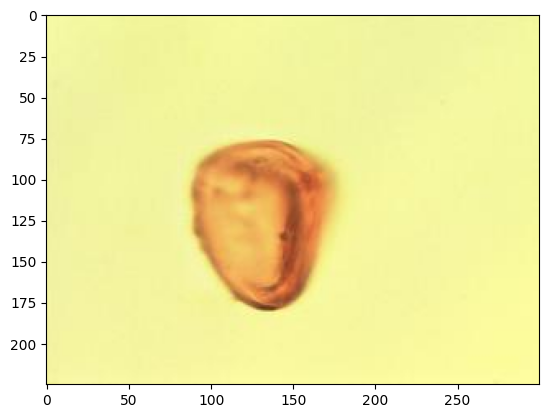

In [5]:
api_base_url = "https://api.globalpollenproject.org"
endpoint = "/api/v1/collection"
id_parameter_value = "a11174bb-2021-4a1a-b76c-4a19e3c3d233"
url_with_parameters = f"{api_base_url}{endpoint}?id={id_parameter_value}"


# Make the API request
try:
    response = requests.get(url_with_parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Get the photo URL from the JSON response
        nested_structure = data.get("Slides")
        photo_url = nested_structure[0].get("Thumbnail") if nested_structure else None
        if photo_url:
            # Retrieve the image from the URL
            image_response = requests.get(photo_url)
            image_data = BytesIO(image_response.content)

            # Open and display the image using matplotlib
            img = Image.open(image_data)
            plt.imshow(img)
            plt.show()
        # Now you can work with the data
        #print(data)

    else:
        print(f"Error: {response.status_code}, {response.text}")

except requests.exceptions.RequestException as e:
    print(f"Request error: {e}")

In [6]:
id_list = ["5403f690-10c1-4927-9c06-8af7b5c03ab1", "dce5c439-7428-4de0-8586-652cf6c6d426",
           "56149a4d-13eb-4698-b244-0e06c6f5b9ae", "61ec04a1-ba7f-4942-9cb0-4873b7bf18b6",
           "3a8cd684-9423-4a99-af12-02c9fcd039ba", "9a612d33-2249-4722-8477-9ded722c3d9e"]
classes = ['Rubiaceae', 'Ranunculaceae', 'Malvaceae', 'Euphorbiaceae', 'Ericaceae', 'Caryophyllaceae']
df = pd.DataFrame(columns=['classes', 'index', 'image'])
data_list = []
for index, id in enumerate(id_list):
  id_parameter_value = id
  url_with_parameters = f"{api_base_url}{endpoint}?id={id_parameter_value}"

  # Make the API request
  try:
      response = requests.get(url_with_parameters)
      # Check if the request was successful (status code 200)
      if response.status_code == 200:
          # Parse the JSON response
          data = response.json()

          # Get the photo URL from the JSON response
          nested_structure = data.get("Slides")

          for img_index, image in enumerate(nested_structure):
            photo_url = image.get("Thumbnail") if nested_structure else None
            if photo_url:
                # Retrieve the image from the URL
                image_response = requests.get(photo_url)
                image_data = BytesIO(image_response.content)

                # Open and display the image using matplotlib
                img = Image.open(image_data)
                data_list.append({'classes': classes[index], 'index': img_index, 'image': np.array(img)})
                img.close()

      else:
          print(f"Error: {response.status_code}, {response.text}")

  except requests.exceptions.RequestException as e:
      print(f"Request error: {e}")

  df = pd.concat([pd.DataFrame([item]) for item in data_list], ignore_index=True)


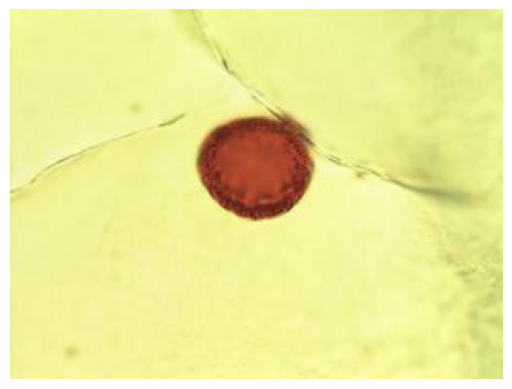

In [7]:
import numpy as np
# Display the first image in the DataFrame
first_image = df['image'].iloc[0]

# Display the image using matplotlib
plt.imshow(first_image, cmap='gray')  # 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame with 'classes' column
le = LabelEncoder()
df['encoded_classes'] = le.fit_transform(df['classes'])

In [9]:
import tensorflow as tf
import tensorflow.keras.utils
target_size = (224, 224, 3)
resized_images = [np.resize(img, target_size) for img in df['image']]
normalized_images = [img / 255.0 for img in resized_images]
X = np.array(normalized_images)
y = tf.keras.utils.to_categorical(df['encoded_classes'])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)
print("Testing set shape:", X_test.shape)
print("Testing set shape:", y_test.shape)


Training set shape: (304, 224, 224, 3)
Training set shape: (304, 6)
Testing set shape: (77, 224, 224, 3)
Testing set shape: (77, 6)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Clear Keras session
K.clear_session()

epochs = 100
num_classes = len(classes)

# Load pre-trained MobileNetV2 model (excluding the top, which is the classification layer)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Global Average Pooling (GAP) layer
gap_layer = layers.GlobalAveragePooling2D()(base_model.output)

# Freeze the modified base model layers
for layer in base_model.layers:
    layer.trainable = False

n = 1

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=10*n,
  width_shift_range=0.1*n,
  height_shift_range=0.1*n,
  shear_range=0.1*n,
  zoom_range=0.1*n,
  horizontal_flip=True,
  fill_mode='nearest'
)

# Reshape the gap_layer to match the expected input shape for the specialist model
reshaped_gap_layer = layers.Reshape((1, 1, 1280))(gap_layer)

all_models = []
all_predictions = []


# Create a new model with convolutional layers
for class_label in range(num_classes):

    # Create a specialist model
    model = models.Sequential([
        layers.Conv2D(128, (1, 1), activation='relu', input_shape=(1, 1, 1280)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Combine the base model and specialist model into a single model
    combined_model = models.Model(inputs=base_model.input, outputs=model(reshaped_gap_layer))

    # Freeze the layers of the base model
    # for layer in combined_model.layers[:-12]:  # Exclude the last two layers (Dense layers)
    #    layer.trainable = False

    # Train the specialist model
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8, min_lr=0.0001)
    # Set your desired initial learning rate
    initial_learning_rate = 0.0001
    # Create an optimizer with the initial learning rate
    optimizer = Adam(learning_rate=initial_learning_rate)
    combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
    combined_model.fit(datagen.flow(X_train, y_train[:, class_label], batch_size=16),
                      validation_data=(X_test, y_test[:, class_label]),
                      epochs=epochs,
                      callbacks=[early_stopping, reduce_lr])

    all_models.append(combined_model)
    # Collect predictions from the current specialist model
    predictions_class = combined_model.predict(X_test).flatten()
    all_predictions.append(predictions_class)

# Combine predictions from all specialist models
all_predictions = np.array(all_predictions).T  # Transpose to get predictions for each sample
all_predictions = np.argmax(all_predictions, axis=1)

y_test_binary = np.argmax(y_test, axis=1)

# Evaluate binary classification metrics
accuracy_value = accuracy_score(y_test_binary, all_predictions)
precision_value = precision_score(y_test_binary, all_predictions, average='weighted')
recall_value = recall_score(y_test_binary, all_predictions, average='weighted')
f1_value = f1_score(y_test_binary, all_predictions, average='weighted')

# Print overall metrics
print("Overall Metrics:")
print(f"Accuracy: {accuracy_value}")
print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")
print(f"F1-Score: {f1_value}")


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
19/19 [==============================] - 15s 332ms/step - loss: 2.0696 - precision: 0.2165 - recall: 0.7500 - val_loss: 1.8315 - val_precision: 0.3462 - val_recall: 0.6000 - lr: 1.0000e-04
Epoch 2/100
19/19 [==============================] - 4s 226ms/step - loss: 1.7791 - precision: 0.2574 - recall: 0.6250 - val_loss: 1.7034 - val_precision: 0.3810 - val_recall: 0.5333 - lr: 1.0000e-04
Epoch 3/100
19/19 [==============================] - 3s 176ms/step - loss: 1.5533 - precision: 0.3725 - recall: 0.6786 - val_loss: 1.5880 - val_precision: 0.3333 - val_recall: 0.2667 - lr: 1.0000e-04
Epoch 4/100
19/19 [==============================] - 3s 175ms/step - loss: 1.4075 - precision: 0.3768 - recall: 0.4643 - val_loss: 1.4787 - val_precision: 0.4000 - val_recall: 0.1333 - lr: 1.0000e-04
Epoch 5/100
19/19 [==============================] - 4s 228ms/step - loss: 1.2739 - precision: 0.4340 - recall: 0.4107 - val_loss: 1.377

3/3 [==============================] - 1s 45ms/step
Epoch 1/100
19/19 [==============================] - 9s 231ms/step - loss: 1.9101 - precision_5: 0.1930 - recall_5: 0.3729 - val_loss: 1.8432 - val_precision_5: 0.2000 - val_recall_5: 0.1250 - lr: 1.0000e-04
Epoch 2/100
19/19 [==============================] - 3s 181ms/step - loss: 1.6750 - precision_5: 0.3200 - recall_5: 0.4068 - val_loss: 1.7203 - val_precision_5: 0.8000 - val_recall_5: 0.1667 - lr: 1.0000e-04
Epoch 3/100
19/19 [==============================] - 4s 229ms/step - loss: 1.4981 - precision_5: 0.4286 - recall_5: 0.3559 - val_loss: 1.6058 - val_precision_5: 1.0000 - val_recall_5: 0.0417 - lr: 1.0000e-04
Epoch 4/100
19/19 [==============================] - 3s 175ms/step - loss: 1.3718 - precision_5: 0.4762 - recall_5: 0.3390 - val_loss: 1.5002 - val_precision_5: 1.0000 - val_recall_5: 0.1250 - lr: 1.0000e-04
Epoch 5/100
19/19 [==============================] - 3s 176ms/step - loss: 1.2515 - precision_5: 0.5366 - recall_5: 

3/3 [==============================] - 1s 42ms/step
Overall Metrics:
Accuracy: 0.45454545454545453
Precision: 0.5033151059466848
Recall: 0.45454545454545453
F1-Score: 0.46036510652017704


In [13]:
y_test_binary = np.argmax(y_test, axis=1)
y_test_binary

array([1, 3, 5, 5, 5, 5, 3, 0, 2, 4, 0, 2, 1, 3, 5, 3, 5, 0, 2, 2, 0, 4,
       5, 1, 0, 2, 5, 4, 0, 5, 5, 5, 5, 1, 0, 4, 4, 2, 5, 0, 2, 4, 1, 0,
       5, 5, 5, 4, 5, 5, 4, 2, 0, 3, 4, 2, 4, 5, 0, 5, 2, 0, 3, 1, 4, 0,
       5, 0, 5, 5, 4, 4, 3, 5, 2, 1, 0])

In [14]:
# Combine predictions from all specialist models
all_predictions = np.array(all_predictions).T  # Transpose to get predictions for each sample

y_test_binary = np.argmax(y_test, axis=1)

# Evaluate binary classification metrics
accuracy_value = accuracy_score(y_test_binary, all_predictions)
precision_value = precision_score(y_test_binary, all_predictions)
recall_value = recall_score(y_test_binary, all_predictions)
f1_value = f1_score(y_test_binary, all_predictions)

# Print overall metrics
print("Overall Metrics:")
print(f"Accuracy: {accuracy_value}")
print(f"Precision: {precision_value}")
print(f"Recall: {recall_value}")
print(f"F1-Score: {f1_value}")

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
all_predictions